### GLAZER FITTING: Explicit refinement of Glazer modes in a PDF of CaTiO3

In [1]:
# Import packages that we will need.
import os
import yaml
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(os.path.join("utils",
                            "billinge.mplstyle"))

from diffpy.srfit.fitbase import FitContribution, FitRecipe, FitResults, Profile, FitHook
from diffpy.srfit.fitbase.fitresults import initializeRecipe
from diffpy.srfit.structure import constrainAsSpaceGroup
from diffpy.srfit.pdf import PDFParser, PDFGenerator
from diffpy.structure import Structure
from scipy.optimize import least_squares

import numpy as np
from sympy import *
np.seterr(invalid='ignore')

%matplotlib inline

In [20]:
def create_tilt_dict(glazer_system, glazer_tilts): 
    """Constructs and initializes the Glazer tilt parameter dictionary
    Constructs the Glazer tilts amplitudes and correct number of
    variables by checking the degrees of freedom of the Glazer 
    system and using amplitudes for the glazer tilts around each axis.

    Parameters
    ----------
    glazer_system : integer
       the number of the Glazer system.
    glazer_tilts :       dict
       contains the three glazer tilt variables alpha_i, beta_i and gamma_i
       and their start values

    Returns
    ----------
    tilt_values :   dict, 
       the values of the three tilts, alpha_i, beta_i and gamma_i
    """
    
    a = 0
    b = 0
    c = 0
    
    alpha_i = list(glazer_tilts.values())[0]
    beta_i = list(glazer_tilts.values())[1]
    gamma_i = list(glazer_tilts.values())[2]

    # Checking for number of active tilt variables depending on the Glazer system:
    if glazer_system in [22, 21, 20, 16, 14, 11, 7, 3]:
        print('This Glazer system has one tilt degree of freedom. \nPlease make sure you have set alpha_i')
        a = alpha_i
    if glazer_system in [19, 18, 17, 15, 13, 10, 9, 6, 5, 2]:
        print('This Glazer system has two tilt degrees of freedom. \nPlease make sure you have set alpha_i and beta_i.')
        a = alpha_i
        b = beta_i
    if glazer_system in [12, 4, 1]:
        print('This Glazer system has three tilt degrees of freedom. \nPlease make sure you have set alpha_i, beta_i, GAMMA_I.')
        a = alpha_i
        b = beta_i
        c = gamma_i

    tilts_dict = {23: {'alpha': 0, 'beta': 0, 'gamma': 0}, 22: {'alpha': 0, 'beta': 0, 'gamma': -a}, 
               21: {'alpha': 0, 'beta': 0, 'gamma': a}, 20: {'alpha': 0, 'beta': -a, 'gamma': -a}, 
               19: {'alpha': 0, 'beta': -a, 'gamma': -b}, 18: {'alpha': 0, 'beta': a, 'gamma': -b}, 
               17: {'alpha': 0, 'beta': a, 'gamma': -b}, 16: {'alpha': 0, 'beta': a, 'gamma': a}, 
               15: {'alpha': 0, 'beta': a, 'gamma': b}, 14: {'alpha': -a, 'beta': -a, 'gamma': -a}, 
               13: {'alpha': -a, 'beta': -a, 'gamma': -b}, 12: {'alpha': -a, 'beta': -b, 'gamma': -c},
               11: {'alpha': a, 'beta': -a, 'gamma': -a}, 10: {'alpha': a, 'beta': -b, 'gamma': -b}, 
               9: {'alpha': a, 'beta': -a, 'gamma': -b}, 8: {'alpha': a, 'beta': -b, 'gamma': -c}, 
               7: {'alpha': a, 'beta': a, 'gamma': -a}, 6: {'alpha': a, 'beta': b, 'gamma': -b},
               5: {'alpha': a, 'beta': a, 'gamma': -b}, 4: {'alpha': a, 'beta': b, 'gamma': -c}, 
               3: {'alpha': a, 'beta': a, 'gamma': a}, 2: {'alpha': a, 'beta': b, 'gamma': b}, 
               1: {'alpha': a, 'beta': b, 'gamma': c}}
    
    try:
        tilt_values = tilts_dict[glazer_system]
        print('Refinement will start with values {}. \nPositive values signify in-phase tilt, negative values signify out-of-phase tilt.\n'.format(list(tilt_values.values())))
    except:
        print('Found no start values for the the Glazer tilt amplitudes (alpha_i, beta_i and/or GAMMA_I)')
    return tilt_values


In [3]:
def create_Aconstraints(glazer_system, adisp):
	""" Constructs and initializes constraints, variables and  start values for the A sites.
	Constructs and initializes constraint equations, list of variables 
	and their start values for the A sites based on the glazer system 
	ID and displacements of the A cations from their high-symmetry
	positions.

    Parameters
    ----------
    glazer_system : integer
       the number of the Glazer system.
	adisp : dict
	   contains the variables for displacement along different axes and 
	   their initial values.

    Returns
    ----------
    acons :   8x3 matrix of strings
	   gives the constraint equations for the atomic positions
	avars :   list of strings
	   variables used in the constraints equations
	adispvals_i :  list of floats
	   initial values for A cation displacements
    """
	
	print('Setting up constraints and variables for the A cations in Glazer system {}.'.format(glazer_system))
	
	if glazer_system == 10:
		# Variables for the A sites
		avars = list(adisp.keys())
		avars = [v.split('_')[0] for v in avars]
		# Constraints for the eight A sites.
		acons = [[None, '0.25+{}'.format(avars[0]), '0.25+{}'.format(avars[1])], 
 				[None, '0.25+{}'.format(avars[0]), '0.75+{}'.format(avars[1])], 
 				[None, '0.75+{}'.format(avars[0]), '0.25+{}'.format(avars[1])], 
 				[None, '0.75+{}'.format(avars[0]), '0.75+{}'.format(avars[1])], 
 				[None, '0.25-{}'.format(avars[0]), '0.25-{}'.format(avars[1])], 
 				[None, '0.25-{}'.format(avars[0]), '0.75-{}'.format(avars[1])], 
 				[None, '0.75-{}'.format(avars[0]), '0.25-{}'.format(avars[1])], 
 				[None, '0.75-{}'.format(avars[0]), '0.75-{}'.format(avars[1])]]
		
		adispvals_i = list(adisp.values())
		print('Refinement will start with values {}.\n'.format(adispvals_i))
		
	else:
		print('You have chosen Glazer system {}. A cation constraints for this system are yet undefined.\n'.format(glazer_system))
	
	return acons, avars, adispvals_i

In [4]:
"""
Here we define the rotation/tilt patterns of all eight octahedra in a 2x2x2
supercell of the perovskite structure. alpha, beta and gamma are the
tilts around x, y and z respectively. IP and OOP denotes whether adjacent
layers of octahedra in the tilt pattern tilt in-phase or out-of-phase.
A clockwise or anti-clockwise tilt is given for each of the 8 octahedra.
The octahedra are labeled according to the position of their center B site. 
"""
rotation_pattern = {

'alpha': {'IP': {'clockwise': [[0, 0, 0], [0, 0.5, 0.5], [0.5, 0, 0], [0.5, 0.5, 0.5]],
                 'anti-clockwise': [[0, 0, 0.5], [0, 0.5, 0], [0.5, 0, 0.5], [0.5, 0.5, 0]]},
         'OOP': {'clockwise': [[0, 0, 0], [0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]], 
                 'anti-clockwise': [[0, 0, 0.5], [0, 0.5, 0], [0.5, 0, 0], [0.5, 0.5, 0.5]]}},

'beta': {'IP': {'clockwise': [[0, 0, 0], [0.5, 0, 0.5], [0, 0.5, 0], [0.5, 0.5, 0.5]], 
                'anti-clockwise': [[0.5, 0, 0], [0.5, 0.5, 0], [0, 0, 0.5], [0, 0.5, 0.5]]}, 
        'OOP': {'clockwise': [[0, 0, 0], [0.5, 0, 0.5], [0.5, 0.5, 0], [0, 0.5, 0.5]], 
                'anti-clockwise': [[0.5, 0, 0], [0, 0, 0.5], [0, 0.5, 0], [0.5, 0.5, 0.5]]}},

'gamma': {'IP': {'clockwise': [[0, 0, 0], [0.5, 0.5, 0], [0, 0, 0.5], [0.5, 0.5, 0.5]], 
                 'anti-clockwise': [[0.5, 0, 0], [0, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]]}, 
         'OOP': {'clockwise': [[0, 0, 0], [0.5, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]], 
                 'anti-clockwise': [[0.5, 0, 0], [0, 0.5, 0], [0, 0, 0.5], [0.5, 0.5, 0.5]]}}                
}

In [5]:
def rotate_octahedron(octahedron, tilt_values):
    """Rotates the octahedron around the three cartesian axes
    Takes in the atomic positions of the B atom and X atoms in an octahedron and a
    dict of tilt values and returns the displacement constraints
    for the X atoms of the octahedron as symbolic expressions and a list of
    Glazer variables to be refined.

    Parameters
    ----------
    octahedron :    4x3 matrix of atomic positions (floats)
    tilt_values :   dict of tilt labels and values.

    Returns
    ----------
    Xs_cons :        3x3 matrix, symbolic expressions, constraints for the x,y and z oxygen positions
    Glazer_vars :    list, sympy variables for alpha, beta and/or gamma, depinding on the Glazer system
    """
    # Make empty dictionaries for the amplitudes (amp), the indicators for
    # in-phase or out-of-phase tilt around the three axes (pattern_indicator)
    # sign for clockwise or anti-clockwise rotation for each octahedron (sign)
    # and the constraints equations for the X atoms as symbolic expressions.
    amp = {}
    pattern_indicator = {}
    sign = {}
    Xs_disp = {}
    
    # Define the cartesian axes
    axes = np.array([[1,0,0], [0,1,0], [0,0,1]])
    
    # Fetch initial position for pivot atom (B) and the three oxygens (X):
    B = octahedron[0]
    Xs = octahedron[1:4]
    # Shift the octahedron to the origin:
    Xs_rel = Xs - B
    
    # define active variables
    glazer_vars = [Symbol('alpha_var'), Symbol('beta_var'), Symbol('gamma_var')]
    amps = tilt_values['alpha'], tilt_values['beta'], tilt_values['gamma']
    for i in [1,2]:
        # if amplitudes are the same around two different axes
        if abs(amps[i]) == abs(amps[i-1]):
            # give the same tilt variable (alpha, beta or gamma) for those axes
            glazer_vars[i] = glazer_vars[i-1]
    
    for i in range(len(glazer_vars)):
        if amps[i] == 0:
            glazer_vars[i] = 0

    # Go through all the Glazer amplitudes, alpha, beta and gamma, and 
    # fetch relevant rotation/tilt pattern.
    i = 0
    for key in tilt_values.keys():
        amp[key] = np.abs(float(tilt_values[key]))
        pattern_indicator[key] = np.sign(tilt_values[key])
        if amp[key] > 0:
            if pattern_indicator[key] > 0:
                typ = 'IP'
            elif pattern_indicator[key] < 0:
                typ = 'OOP'
                
            # set sign of rotation for the current octahedron
            if list(B) in rotation_pattern[key][typ]['clockwise']:
                sign[key] = +1
            elif list(B) in rotation_pattern[key][typ]['anti-clockwise']:
                sign[key] = -1
            
        elif amp[key] == 0:
            sign[key] = 0
        
        # Define displacement from cubic position around axis 
        R = axes[i]
        Xs_disp[key] = symarray('', len(Xs))
        for j in range(len(Xs_rel)):
            x = Xs_rel[j]
            disp_dir = Matrix(np.nan_to_num(np.cross(R, x) / np.linalg.norm(np.cross(R, x))))
            x_scaled = Matrix(x).multiply(cos(glazer_vars[i]/180*pi)) # length of vector*cosine
            x_scaled_len = sqrt((x_scaled[0])**2 + (x_scaled[1])**2 + (x_scaled[2])**2)
            disp_amp = x_scaled_len * tan(sign[key]*glazer_vars[i]/180*pi)
            x_disp = disp_dir * disp_amp
            Xs_disp[key][j] = x_disp
    
        i = i+1
    
    # Combining all relative displacements around all three axes
    Xs_disp_all = Xs_disp['alpha'] + Xs_disp['beta'] + Xs_disp['gamma']
    
    # Create constraints equations for all oxygens by adding the old positions
    Xs_cons = symarray('', len(Xs))
    for i in range(len(Xs)):
        Xs_cons[i] = Xs_disp_all[i] + Matrix(Xs[i])

    return Xs_cons, glazer_vars

In [6]:
def create_lattice_parameters_constraints(octahedron_disp, latpar_a, nx, ny, nz):
    """Creates constraints for the lattice parameters
    Takes in positions of the atoms in an octahedron (symbolic expressions),
    a variable for the cubic perovskite lattice parameter (symbolic) and
    the supercell dimensions nx, ny, nz (integers) and returns constraints 
    for the lattice parameters (symbolic expressions).

    Parameters
    ----------
    octahedron_disp :  4x3 matrix of symbolic expressions
       atomic positions of any octahedron
    latpar_a :            sympy variable
       cubic lattice parameter
    nx, ny, nz :       int x 3
       dimensions of the supercell   

    Returns
    ----------
    a_new :     symbolic expression
       constraint equation for the a lattice parameter
    b_new :     symbolic expression
       constraint equation for the b lattice parameter
    c_new :     symbolic expression
       constraint equation for the c lattice parameter
    """

    print('Setting up constraints for the lattice parameters using the Glazer tilt variables.\n')

    # Breaking up the octahedron in the pivot atom and three oxygens:
    B = octahedron_disp[0]
    X1 = octahedron_disp[1]
    X2 = octahedron_disp[2]
    X3 = octahedron_disp[3]

    # Shifting the octahedron to the origin:
    O1x, O1y, O1z = X1 - B
    O2x, O2y, O2z = X2 - B
    O3x, O3y, O3z = X3 - B
    
    # Using the solutions from evaluating the compression of the supercell, 
    # define scaling factors for the lattice parameters. See paper for details
    # on derivation of these expressions.
    a_num = 1 - 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) - 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    a_den = 1 - 16*O1y**2 + 16*(-1+16*O3y**2)*O1z**2 + 256*(O1y**2-O3y**2)*O2z**2
    scale_a = sqrt(a_num/a_den)

    b_num = 1 - 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) - 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    b_den = 1 + 16*O2x**2 *(-1 + 16*O1z**2) - 16*O2z**2 + 256*O3x**2 *(-O1z**2 + O2z**2)
    scale_b = sqrt(b_num/b_den)

    c_num = -1 + 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) + 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    c_den = -1 + O3x**2 *(16-256*O1y**2) + 256*O2x**2 *(O1y**2 - O3y**2) + 16*O3y**2
    scale_c = sqrt(c_num/c_den)
    
    # Divide the cubic lattice parameters with the scaling factors for each axis:
    a = Symbol(latpar_a)
    a_new = a*nx/scale_a
    b_new = a*ny/scale_b
    c_new = a*nz/scale_c
    
    return a_new, b_new, c_new

In [21]:
# Test for creating all the constraints
octa = np.array([[0.0, 0.5, 0.0],
                [0.25, 0.5, 0.0],
                [0.0, 0.75, 0.],
                [0.0, 0.5, 0.25]])
glazerID = 10
glazer_tilts = {'alpha_i': 9, 'beta_i': 10, 'gamma_i': None}
adisp = {'aydisp_i': 0.02, 'azdisp_i': 0.01}

a_cons, a_vars, a_dispvals_i = create_Aconstraints(glazerID, adisp)
print("Constraints for the A cation positions: \n {}\n".format(a_cons))
tilt_values = create_tilt_dict(glazerID, glazer_tilts)

Xs_new_test, variables_active = rotate_octahedron(octa, tilt_values)
print("Constraints for the new oxygen positions expressed as a function of Glazer tilts: \n {}\n".format(Xs_new_test))

octa_disp = Matrix(octa[0]), Xs_new_test[0], Xs_new_test[1], Xs_new_test[2]
a_new_test, b_new_test, c_new_test = create_lattice_parameters_constraints(octa_disp, 'a_cubic', 2, 2, 2)
print("Constraints for the new lattice parameters expressed as a function of Glazer tilts: \na: {},\nb: {},\nc: {}".format(a_new_test, b_new_test, c_new_test))

Setting up constraints and variables for the A cations in Glazer system 10.
Refinement will start with values [0.02, 0.01].

Constraints for the A cation positions: 
 [[None, '0.25+aydisp', '0.25+azdisp'], [None, '0.25+aydisp', '0.75+azdisp'], [None, '0.75+aydisp', '0.25+azdisp'], [None, '0.75+aydisp', '0.75+azdisp'], [None, '0.25-aydisp', '0.25-azdisp'], [None, '0.25-aydisp', '0.75-azdisp'], [None, '0.75-aydisp', '0.25-azdisp'], [None, '0.75-aydisp', '0.75-azdisp']]

This Glazer system has two tilt degrees of freedom. 
Please make sure you have set alpha_i and beta_i.
Refinement will start with values [9, -10, -10]. 
Positive values signify in-phase tilt, negative values signify out-of-phase tilt.

Constraints for the new oxygen positions expressed as a function of Glazer tilts: 
 [Matrix([
 [                                                          0.25],
 [-0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180) + 0.5],
 [       0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180

In [30]:
def plotresults(recipe, resfithook, figname):
    """Plots fit results.
    Creates plots of the fitted PDF and residual, displays them, and
    then writes them to disk as *.pdf files.

    Parameters
    ----------
    recipe :     Fit Recipe object
       contains the optimized calculated PDF data we wish to plot
    resfithook : Diffpy recipe object
       contains the optimized variables and goodness of fit for each iteration.
    figname :    string
       the location and name of the figure file to create

    Returns
    ----------
    None
    """
    r = recipe.crystal.profile.x

    g = recipe.crystal.profile.y
    gcalc = recipe.crystal.profile.ycalc
    diffzero = -0.65 * max(g) * np.ones_like(g)
    diff = g - gcalc + diffzero


    fig, ax = plt.subplots(2, 1)

    ax[0].plot(r, g, ls="None",
             marker="o", ms=3, mew=0.2,
             mfc="None", label="$G(r)$ Data")
    ax[0].plot(r, gcalc, lw=1.3, label="$G(r)$ Fit")
    ax[0].plot(r, diff, lw=1.2, label="$G(r)$ diff")
    ax[0].plot(r, diffzero, lw=1.0, ls="--", c="black")
    ax[0].set_xlabel("$r$ [$\mathrm{\AA}]$")
    ax[0].set_ylabel("$G$ [$\mathrm{\AA}$$^{-2}$]")
    ax[0].set_title("Observed PDF and calculated PDF from Glazer model")
    ax[0].tick_params(axis="both",
                    which="major",
                    top=True,
                    right=True)
    ax[0].set_xlim(rmin, rmax)
    ax[0].legend(loc=0, ncol=3)
    

    ax[1].plot(resfithook.rws, lw=1.0, marker='o', c="black")
    ax[1].set_xlabel("iteration")
    ax[1].set_ylabel(r"$R_w$")
    ax[1].set_title(r"Progression of $R_w$ through the refinement")
    ax[1].tick_params(axis="both",
                    which="major",
                    top=True,
                    right=True)

    plt.tight_layout()
    plt.show()
    fig.savefig(figname + ".pdf", format="pdf")

    # End of function

In [33]:
def makerecipe(model, gr_path, rmin, rmax, rstep, qmin, qmax, element_a, element_b,
               element_x, scale_i, delta2_i, latpar_a_cub_i, uiso_a_i, uiso_b_i, uiso_x_i):
    """Creates and returns a Fit Recipe object.
    Makes the recipe that the fit will follow using the PDF data,
    the model structure, fit specifications and initial values of
    the variables to be refined. The constraints and variables
    necessary to run the fit are created using separate functions.

    Parameters
    ----------
    model :           diffpy structure object
       contains the structure model used to fit the PDF data
    gr_path :         string
       the path to the PDF data to be fit
    rmin :            float
       lower boundary of r range for fitting
    rmax :            float
       higher boundary of r range for fitting
    rstep :           float
       step size of increments in r
    qmin :            float
       lower boundary of Q space used in the Fourier transform to G(r)
    qmax :            float
       higher boundary of Q space used in the Fourier transform to G(r)
    element_a :       string
       A cation element in the perovskite
    element_b :       string
       B cation element in the perovskite
    element_x :       string
       X anion element in the perovskite
    scale_i :         float
       initial scaling factor of the calculated PDF
    delta2_i :        float
       initial nearest-neighbor correlation
    latpar_a_cub_i :  float
       initial cubic lattice parameter
    uiso_a :          float
       initial temperature parameter Uiso value for the A cation
    uiso_b :          float
       initial temperature parameter Uiso value for the B cation
    uiso_x :          float
       initial temperature parameter Uiso value for the X anion


    Returns
    ----------
    fitrecipe : Fit Recipe object
       Contains information about the data, model, variables to be refined,
       initial values and constraints for all relevant parameters.
    """

    ########################### Profile Section ###################################
    # Create a Profile object for the experimental dataset. This handles all details
    # about the dataset. We also tell this profile the range and mesh of points in 
    # r-space.
    
    profile = Profile()
    parser = PDFParser()
    parser.parseFile(gr_path)
    profile.loadParsedData(parser)
    profile.setCalculationRange(xmin=rmin, xmax=rmax, dx=rstep)

    ########################## PDF Generator Section ##############################
    # Create a PDF Generator object for a periodic structure model. Here we name it
    # "G1" and we give it the structure object. This Generator will later compute
    # the model PDF for the structure object we provide it here.
    generator_crystal = PDFGenerator("G1")
    generator_crystal.setStructure(model, periodic=True)

    # Initialize the instrument parameters, Q_damp and Q_broad, and assign Q_max and
    # Q_min, all part of the PDF Generator object. It's possible that the PDFParse
    # function we used above already parsed out ths information, but in case it
    # didn't, we set it explicitly again here. All parameter objects can have their
    # value assigned using the below ".value = " syntax.
    generator_crystal.qdamp.value = qdamp
    generator_crystal.qbroad.value = qbroad
    generator_crystal.setQmax(qmax)
    generator_crystal.setQmin(qmin)

    # If you have a multi-core computer (you probably do), you can run your 
    # refinement in parallel! This requires that you set "RUN_PARALLEL" to "True" 
    # above. The psutil python package is also required for the bit of code below,
    # where we make sure not to overload your CPUs.
    if RUN_PARALLEL:
        import psutil
        import multiprocessing
        syst_cores = multiprocessing.cpu_count()
        cpu_percent = psutil.cpu_percent()
        avail_cores = np.floor((100 - cpu_percent) / (100.0 / syst_cores))
        ncpu = int(np.max([1, avail_cores]))
        generator_crystal.parallel(ncpu)

    ######################### Fit Contribution Section ############################
    # Create a Fit Contribution object, and name it "crystal." We then give the PDF
    # Generator object we created just above to this Fit Contribution object.
    # The Fit Contribution holds the equation used to fit the PDF.
    contribution = FitContribution("crystal")
    contribution.addProfileGenerator(generator_crystal)

    # Set an equation, within the Fit Contribution, based on your PDF Generators.
    # Here we simply have one Generator, G1, and a scale variable, s1.
    # Using this structure is a very flexible way of adding additional
    # Generators (ie. multiple structural phases), experimental Profiles,
    # PDF characteristic functions (ie. shape envelopes), and more.
    contribution.setEquation("s1*G1")

    # Set the experimental profile, within the Fit Contribution object, to the 
    # Profile object we created earlier.
    contribution.setProfile(profile, xname="r")

    ######################### Recipe Section ######################################
    # Create the Fit Recipe object that holds all the details of the fit, defined in
    # the lines above. We give the Fit Recipe the Fit Contribution we created earlier.
    recipe = FitRecipe()
    recipe.addContribution(contribution)

    # Configure some additional fit variables pertaining to symmetry. We can use the
    # srfit function constrainAsSpaceGroup to constrain the lattice and ADP
    # parameters. We are not using symmetry constraints in this code, but we still
    # initialize a P1 symmetry so that we can use the parameters generated to create
    # our own constraints.
    # First we establish the relevant parameters, splitting the structure into its 
    # elemental sublattices, A, B and X then we cycle through the parameters and
    # activate and tag them. This gives us the flexibility to use symmetry constraints
    # for the A cations will creating our Glazer tilt constraints manually. We must 
    # explicitly set the ADP parameters, because in this case, the CIF has no ADP data.
    # Currently, the A atoms are also constrained manually, so we initialize P1 for all
    # atoms.
    
    #Get the atoms:
    atoms = generator_crystal.phase.getScatterers()
    # Sorting the atoms by element. Based on a 2x2x2 perovskite structure.
    A_atoms = atoms[0:8]
    X_atoms = atoms[16:]
    
    spacegroupparams_A = constrainAsSpaceGroup(generator_crystal.phase,
                                             'P1', scatterers=A_atoms,
                                              constrainlat=False)
    spacegroupparams_X = constrainAsSpaceGroup(generator_crystal.phase,
                                             'P1', scatterers=X_atoms)
    
    # Create dicts of position and lists of indices for all three atom types.
    A_dict, B_dict, X_dict = {}, {}, {}
    A_index, B_index, X_index  = [], [], []
    for i,atom in enumerate(atoms):
        if atom.element == element_x:
            X_index.append(i)
            X_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}
        elif atom.element == element_b:
            B_index.append(i)
            B_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}
        elif atom.element == element_a:
            A_index.append(i)
            A_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}

    # Picking out the indices that describe the three types of anions. Keep in
    # mind that the numbers depend on the order of atoms in the loaded cif.
    x1_index = X_index[0*8:8*1]
    x2_index = X_index[1*8:8*2]
    x3_index = X_index[2*8:8*3]
    
    # Create dict for indices and xyzpars of oxygen spacegroup params
    index_xyzpars_X_dict = {}
    for par in spacegroupparams_X.xyzpars:
        atom_index = int(par.name.split("_")[-1]) +16
        if not atom_index in index_xyzpars_X_dict.keys():
            index_xyzpars_X_dict[atom_index] = [par]
        elif atom_index in index_xyzpars_X_dict.keys():
            index_xyzpars_X_dict[atom_index].append(par)
    
    index_xyzpars_A_dict = {}
    for par in spacegroupparams_A.xyzpars:
        atom_index = int(par.name.split("_")[-1])
        if not atom_index in index_xyzpars_A_dict.keys():
            index_xyzpars_A_dict[atom_index] = [par]
        elif atom_index in index_xyzpars_A_dict.keys():
            index_xyzpars_A_dict[atom_index].append(par)
    
    ######################## VARIABLES and CONSTRAINTS #################################
    ####################################################################################
    # Now that we have the parameters, we can set up the structure variables that are 
    # to be refined, and the values they are to be initialized with.
    
    # Add a variable to the Fit Recipe object, initialize the variables with some value, 
    # and tag it with a string. Here we add the scale parameter from the Fit Contribution,
    # delta and instrumental parameters. The ".addVar" method can be used generally to add
    # variables to the Fit Recipe.
    recipe.addVar(contribution.s1, scale_i, tag="scale")
    recipe.addVar(generator_crystal.delta2, name="Delta2", value=delta2_i, tag="d2")
    recipe.addVar(generator_crystal.qdamp, name="qdamp", value=qdamp, tag="qdamp")
    recipe.addVar(generator_crystal.qbroad, name="qbroad", value=qbroad, tag="qbroad")
    
    # For the atom positions, we have to create new variables, since we are not using
    # the parameters that come out of the ConstrainAsSpacegroup directly. Then we can
    # link these new variables to the parameters. Note that the variable names given 
    # here are the same as those used in the A_con list, as initialized in cell 3.
    
    # Variables, start values and constraints for A cations
    A_cons, A_vars, A_dispvals_i = create_Aconstraints(glazer_system, adisp)
    for Avar, AvarI in zip(A_vars, A_dispvals_i):     
        recipe.newVar(Avar, AvarI, tag=Avar)

    for i in range(len(A_cons)):
        for j in range(3):
            A_par = index_xyzpars_A_dict[i][j]
            A_con = A_cons[i][j]
            if A_con != None:
                recipe.constrain(A_par, "{}".format(A_con))
    
    
    # Initialize variables for the cubic lattice parameter
    recipe.newVar("latpar_a_cub_var", latpar_a_cub_i, tag="latpar_a_cub")

    # Go through all the octahedra and fetch variable expressions for the constraints
    # Use the first octahedron to initizalize the glazer variables

    tilt_values = create_tilt_dict(glazer_system, glazer_tilts)

    print('Setting up constraints for the oxygens using the Glazer tilt variables.\n')
    for n in range(len(B_index)):
        # Find the atoms in the unit and define vectors between the X's and
        # B cation, setting B as a reference point around which to rotate:
        B_pos = B_dict[str(B_index[n])][element_b]
        X1_pos = X_dict[str(x1_index[n])][element_x]
        X2_pos = X_dict[str(x2_index[n])][element_x]
        X3_pos = X_dict[str(x3_index[n])][element_x]
        octahedron = np.array([B_pos, X1_pos, X2_pos, X3_pos])
        Xs_con, glazer_vars = rotate_octahedron(octahedron, tilt_values)

        # Create variables for the active glazer tilt variables:
        if n == 0:
            glazer_vars = [var for var in glazer_vars if var != 0]
            i = 0
            l = []
            for v in glazer_vars:
                if v not in l:
                    recipe.newVar("{}".format(v), list(tilt_values.values())[i], fixed=False, tag="{}".format(v))
                    l.append(v)
                i = i + 1

        # Loop through all x, y and z components and add constraints
        for i in range(3):
            X1_par = index_xyzpars_X_dict[x1_index[n]][i]
            X2_par = index_xyzpars_X_dict[x2_index[n]][i]
            X3_par = index_xyzpars_X_dict[x3_index[n]][i]

            X1_con = Xs_con[0][i]
            X2_con = Xs_con[1][i]
            X3_con = Xs_con[2][i]

            recipe.constrain(X1_par, "{}".format(X1_con))
            recipe.constrain(X2_par, "{}".format(X2_con))
            recipe.constrain(X3_par, "{}".format(X3_con))
    
    # Set up constraints for the lattice parameters based on the refinable variables for
    # the cubic lattice parameter latpar_a_cub_var and the glazer tilt amplitudes relevant for the mode
    B = B_dict[str(B_index[-1])][element_b]
    octa_disp = Matrix(B), Xs_con[0], Xs_con[1], Xs_con[2]
    a_con, b_con, c_con = create_lattice_parameters_constraints(octa_disp, 'latpar_a_cub_var', 2, 2, 2)
    
    for par in spacegroupparams_X.latpars:
        if par.name == "a":
            recipe.constrain(par, "{}".format(a_con))
        elif par.name == "b":
            recipe.constrain(par, "{}".format(b_con))
        elif par.name == "c":
            recipe.constrain(par, "{}".format(c_con))
    
    # Add Uiso parameter for each element.
    elements = collections.Counter([atom.element for atom in atoms]).keys()
    dct = {}
    for element in elements:
        if element == element_a:
            var = recipe.newVar(f'Uiso_{element}', value=uiso_a_i, tag=f"Uiso_{element}")
        elif element == element_b:
            var = recipe.newVar(f'Uiso_{element}', value=uiso_b_i, tag=f"Uiso_{element}")
        elif element == element_x:
            var = recipe.newVar(f'Uiso_{element}', value=uiso_x_i, tag=f"Uiso_{element}")
        dct[element] = var
    for atom in atoms:
        recipe.constrain(atom.Uiso, dct.get(atom.element))

    # Return the Fit Recipe object to be optimized
    return recipe

    # End of function


In [17]:
class ResidualFitHook(FitHook):

    def __init__(self):
        super(ResidualFitHook, self).__init__()
        self.rws = []

    def reset(self, recipe):
        self.rws = []

    def postcall(self, recipe, chiv):
        recipe: FitRecipe
        fc: FitContribution = next(iter(recipe._contributions.values()))
        rw = np.sqrt(np.sum(np.power(chiv, 2)) / np.sum(np.power(fc.profile.y, 2)))
        self.rws.append(rw)

In [34]:
def main():
    """Main function for the refinement. 
    Fetches data and model, sets up output directories, calls on the 
    recipe function to make fit recipe and performs the refinement by
    gradually freeing variables. Saves the refinement results and plots
    the final fit and the goodness of fit (rw) as a function of number 
    of refinement iterations.

    Returns
    ----------
    """
    
    # Create a name for the fit based on the compound and chosen Glazer system
    fit_name = "{}_GS_{}".format(compound, glazer_system)
    
    # Make some folders to store our output files.
    resdir = "output/res"  # Contains results (.res)
    vardir = 'output/var/' # Contains only refined variables from results (.yml)
    fitdir = "output/fit"  # Contains fit (.fit)
    figdir = "output/fig"  # Contains plot of fit (.pdf)
    strudir = "output/stru" # Contains refined structures (.cif)
    

    folders = [resdir, fitdir, figdir, strudir, vardir]

    # Loop over all folders
    for folder in folders:

        # If the folder does not exist...
        if not os.path.exists(folder):

            # ...then we create it.
            os.makedirs(folder)


    # Establish the location of the cif file with the structure of interest
    # and load it into a diffpy structure object.
    moddir = os.path.abspath(mpath)
    #if REF_TYPE == 'initial':
    stru1 = Structure(filename=os.path.join(moddir, cif_name))

    # Initialize the Fit Recipe by giving it this diffpy structure
    # as well as the path to the data file.
    #temp = list(filepaths.keys())[0]
    recipe = makerecipe(stru1, dpath+gr_name,  rmin, rmax, rstep, qmin, qmax, 
                        element_a, element_b, element_x, scale_i, delta2_i, 
                        latpar_a_cub_i, uiso_a_i, uiso_b_i, uiso_x_i)
    all_variables = recipe.getNames()
    
    # Set fithooks to get step values
    recipe.fithooks.clear()
    resfithook = ResidualFitHook()
    recipe.fithooks.append(resfithook)

    # Print out list of glazer variables and A cation variables to fit
    A_variables = []
    for v in all_variables:
        if v in ['aydisp', 'azdisp']:
            A_variables.append(v)

    glazer_variables = []
    for v in all_variables:
        if v in ['alpha_var', 'beta_var', 'gamma_var']:
            glazer_variables.append(v)

    refined_dict = dict()

    basename = "{}".format(fit_name) + "_r_{}-{}".format(rmin, rmax)
    
    parser = PDFParser()
    parser.parseFile(dpath+gr_name)
    recipe.crystal.profile.loadParsedData(parser)
    
    ######################### Refinement steps ######################################
    # During the optimization, we fix and free parameters sequentially as you would
    # in PDFgui. This leads to more stability in the refinement. We first fix all
    # variables. "all" is a tag which incorporates every parameter.
    
    # We then run a fit using the SciPy function "least_squares" which takes as its
    # arguments the function to be optimized, here recipe.residual, as well as initial
    # values for the fitted parameters, provided by recipe.values. The x_scale="jac"
    # argument is an optional argument that provides for a bit more stability in the
    # refinement. "least_squares" is a bit more robust than "leastsq," which is another
    # optimization function provided by SciPy. "least_squares" supports bounds on
    # refined parameters, while "leastsq" does not.
     #sys.exit()
    print('Starting refinement {}...'.format(basename))
    recipe.fix("all")
    recipe.free("scale")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("latpar_a_cub_var")
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    for i in range(len(glazer_variables)):
        recipe.fix(glazer_variables[i])
    
    for i in range(len(A_variables)):
        recipe.free(A_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    for i in range(len(A_variables)):
        recipe.fix(A_variables[i])
    for i in range(len(glazer_variables)):
        recipe.fix(glazer_variables[i])

    recipe.free("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    recipe.fix("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    
    recipe.fix("all")
    recipe.free("scale")
    recipe.free("latpar_a_cub_var")
    for i in range(len(A_variables)):
        recipe.free(A_variables[i])
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    least_squares(recipe.residual, recipe.values, x_scale="jac")

    recipe.fix("all")
    recipe.free("scale")
    recipe.free("latpar_a_cub_var")
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")

    recipe.fix("all")
    recipe.free("d2")
    least_squares(recipe.residual, recipe.values, x_scale="jac")

    recipe.free("all")
    recipe.fix("qdamp")
    recipe.fix("qbroad")
    least_squares(recipe.residual, recipe.values, x_scale="jac")

    print('... done!\n')

    # We use the FitResults function to parse out the results from the optimized
    # Fit Recipe.
    res = FitResults(recipe)

    # We use the savetxt method of the profile to write a text file containing the
    # measured and fitted PDF to disk. The file is named based on the basename we
    # created earlier, and written to the fitdir directory.
    profile = recipe.crystal.profile
    profile.savetxt(os.path.join(fitdir, basename + ".fit"))
    print('Dumped {}'.format(os.path.join(fitdir, basename + ".fit")))

    # We use the saveResults method of FitResults to write a text file containing the
    # refined parameters and fit quality indices to disk. The file is named based on
    # the basename we created earlier, and written to the resdir directory.
    header = "{}_{}.\n".format(compound, basename)
    res.saveResults(os.path.join(resdir, basename + ".res"), header=header)
    print('Dumped {}'.format(os.path.join(resdir, basename + ".res")))

    # Write out updated model structure
    pg = recipe.crystal.G1
    stru: diffpy.structure.structure.Structure = pg.stru
    stru.write("{}/{}.cif".format(strudir, basename), "cif")
    print('Dumped {}'.format("{}/{}.cif".format(strudir, basename)))

    refined_dict = dict()
    for name, val in zip(res.varnames, res.varvals):
        # We create a new nested dictionary based on each variable name
        # We store the refined value for this variable using the "value" key.
        # We use the ".item()" method because "res.varvals" exist as
        # numpy.float64 objects, and we want them as regular python floats.
        refined_dict[name] = val.item()

    # We also store the fit rw, for posterity.
    rw = res.rw
    refined_dict['rw'] = rw.item()
    
    # We now write this dictionary to a file for later use.
    outfilename = vardir + fit_name + "_r_" + str(rmin) + "-" + str(rmax) + "_refined_params.yml"
    with open(outfilename, 'w') as outfile:
        yaml.safe_dump(refined_dict, outfile)
    print('Dumped {}'.format(outfilename))

    # We print the results as output.
    print('\nResults from the Glazer fit:')
    res.printResults()

    # We use the plotresults function we created earlier to make a plot of the measured
    # calculated, and difference curves then write a pdf file to disk.
    # The file is named based on the basename we created earlier, and written
    # to the figdir directory.
    plotresults(recipe, resfithook, os.path.join(figdir, basename))

    return

In [19]:
### PARAMETERS AND VARIABLES NOT TO BE REFINED

# Give the elements in the perovskite
element_a = "Ca"
element_b = "Ti"
element_x = "O"
compound = "{}{}{}3".format(element_a, element_b, element_x)

qmax = 23.6
qmin = 0.6

qdamp = 0.0291601718936
qbroad = 0.0103215402787

rmin = 1.6  # Can be changed. Min: 1.6 Å
rmax = 15  # Can be changed. Max: 50 Å
rstep = 0.01

RUN_PARALLEL = True

### Glazer tilt system IDs

#### Group A: High symmetry tilt systems

a0a0a0 ID: 23

a-a-a- ID: 14

a0a0c- ID :22

a0a0c+ ID :21

a0b-b- ID :20

a+b-b- ID :10

#### Group B: Multiple A-site tilt systems

a+a+a+ ID :3

a0b-c+ ID :17

a0b+b+ ID :16

a+a+c- ID :5

#### Group C: transitional/low symmetry tilt systems

a-a-c- ID :13

a0b-c- ID :19

a-b-c- ID :12

a+b-c- ID :8

a+b+c+ ID :1

In [26]:
######## GLAZER SYSTEM ID ################################
glazer_system = 10

######## START VALUES TO BE REFINED ######################
# initial cubic lattice parameter
latpar_a_cub_i =  3.90  
# initial tilt amplitudes (absolute values) around the three crystallagraphic axes
glazer_tilts = {'alpha_i': 8, 'beta_i': 9, 'gamma_i': 9} 
# initial A cation displacements along the relevant crystallographic axes
adisp = {'aydisp_i': 0.02, 'azdisp_i': 0.01}

uiso_a_i = 0.003  # initial value for isotropic Uiso(A)
uiso_b_i = 0.004  # initial value for isotropic Uiso(B)
uiso_x_i = 0.01  # initial value for isotropic Uiso(X)

delta2_i = 1.95202664  # initial value for nearest neighbor correlation
scale_i = 0.2  # initial value for scale

In [27]:
############### LOADING Data and models ##############################
dpath = 'input/data/'
gr_name = 'CaTiO3_x-ray_experimental_200K.gr'

mpath = 'input/models'
cif_name = "CaTiO3_2x2x2-supercell_0_0_0_tilt.cif"   ## This is not optional, it has to be a 2x2x2 cubic supercell

Setting up constraints and variables for the A cations in Glazer system 10.
Refinement will start with values [0.02, 0.01].

This Glazer system has two tilt degrees of freedom. 
Please make sure you have set alpha_i and beta_i.
Refinement will start with values [8, -9, -9]. 
Positive values signify in-phase tilt, negative values signify out-of-phase tilt.

Setting up constraints for the oxygens using the Glazer tilt variables.

Setting up constraints for the lattice parameters using the Glazer tilt variables.

Starting refinement CaTiO3_GS_10_r_1.6-15...
... done!

Dumped output/fit/CaTiO3_GS_10_r_1.6-15.fit
Dumped output/res/CaTiO3_GS_10_r_1.6-15.res
Dumped output/stru/CaTiO3_GS_10_r_1.6-15.cif
Dumped output/var/CaTiO3_GS_10_r_1.6-15_refined_params.yml

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       10.14888435
C

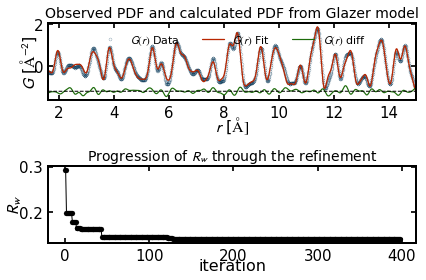

In [28]:
if __name__ == "__main__":
    main()